In [1]:
from standardInclude import *

Welcome to JupyROOT 6.12/06
For interactive plots, run: setint()
To return to non-interactive plots (default state), run: noint()


In [2]:
#f = r.TFile("./data/results_positionsVsTimeVsEnergy_finerBinning_9day.root")
#f = r.TFile("./data/results_positionsVsTimeVsEnergy_finerBinning_ReconEast_9day.root")
#f = r.TFile("./data/results_positionsVsTimeVsEnergy_finerBinning_ReconEast_betterBins_9day.root")
f = r.TFile("./data/results_relativeReconEastEnergies.root")
f.cd("farline/calo2")
#f.ls()

xHistName = "xHitPositionsVsTimeVsEnergy"
yHistName = "yHitPositionsVsTimeVsEnergy"

In [3]:
calo = 8
hx = f.Get("farline").Get("calo"+str(calo)).Get(xHistName).Clone()
hy = f.Get("farline").Get("calo"+str(calo)).Get(yHistName).Clone()
hy.GetYaxis().SetTitle("y-position [xtals]")

In [4]:
fitRange = [0,6]

In [5]:
f1 = r.TF1("f1","gaus", fitRange[0], fitRange[1])
f1.SetParameters(1,1,1)
f1.SetNpx(2000)

In [6]:
#fit function which rejects the regions near crystal centers
#    using TF1::RejectPoint()

def func2(x,p):
    if( x[0] % 1 < 0.52 and x[0] % 1 > 0.48):
        r.TF1.RejectPoint()
        return 0
    else:
        #gaussian: [0]*exp(-0.5*((x-[1])/[2])**2)
        return p[0]*r.TMath.Exp( -0.5*(((x[0]-p[1])/p[2])**2) )
    
f2 = r.TF1("f2", func2, fitRange[0], fitRange[1], 3)
f2.SetParNames("A", "#bar{x}", "#sigma")
f2.SetParameters(1,1,1)
f2.SetLineColor(6)
f2.SetNpx(2000)

In [7]:
f3 = r.TF1("f3",
#           "[0]*TMath::Sqrt(TMath::Pi() / 2.0)*[1]*( TMath::Erf(([2] + x - 2*[3])/(TMath::Sqrt(2)*[1])) + TMath::Erf(([2] - x + 2*[3])/(TMath::Sqrt(2)*[1])) )", 
           "[0]/2*( TMath::Erf(([2] + x - 2*[3])/(TMath::Sqrt(2)*[1])) + TMath::Erf(([2] - x + 2*[3])/(TMath::Sqrt(2)*[1])) )", 
            fitRange[0], fitRange[1], 4)
f3.SetParameters(1,1,1,1)
f3.SetParNames("A","#sigma_{gaus}","r_{square}","#bar{x}")
f3.SetNpx(2000)
f3.SetLineColor(6)

 FCN=7.44463e+06 FROM MIGRAD    STATUS=CONVERGED      84 CALLS          85 TOTAL
                     EDM=1.20772e-08    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.8 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A            4.71011e+05   4.74344e+01  -3.79505e-01  -5.37742e-06
   2  #bar{x}      3.01474e+00   1.23340e-04  -1.04456e-08   1.34474e-01
   3  #sigma       1.38535e+00   9.99204e-05   2.10769e-07  -1.15855e+00


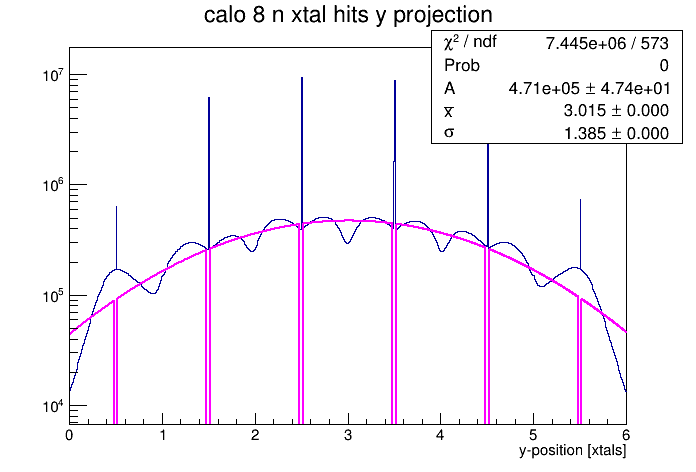

In [8]:
c = r.TCanvas()

hy.GetXaxis().UnZoom()
hy.GetZaxis().UnZoom()
hy.GetZaxis().SetRange(3,5)
hy_y = hy.Project3D("y").Clone()
hy_y.Draw()
f2.SetParameters(10**6,3,1.5)
hy_y.Fit(f2,"R")
#hy_y.GetXaxis().SetRangeUser(2.4,2.6)

#f2.Draw("same")

c.SetLogy()

c.Draw()

In [9]:
focus = "y"

if("y" in focus):
    h3 = hy
elif("x" in focus):
    h3 = hx
else:
    print("Error: please pick x or y")

In [10]:
NbinsEnergy = h3.GetNbinsZ()
NbinsTime = h3.GetNbinsX()
NbinsPosition = h3.GetNbinsY()

print(NbinsEnergy, NbinsTime, NbinsPosition)
energySlices = []
for bin in range(1,NbinsEnergy+1):
    h3.GetZaxis().SetRange(bin,bin)
    eMin = h3.GetZaxis().GetBinCenter(bin) - h3.GetZaxis().GetBinWidth(bin)/2.0
    eMax = h3.GetZaxis().GetBinCenter(bin) + h3.GetZaxis().GetBinWidth(bin)/2.0
    print(bin, eMin, eMax)
    hi = h3.Project3D("yx")#.Clone("hx_E"+str(bin).zfill(2))
    hi.SetTitle("Calo "+str(calo)+
                " Hit Positions vs. Time [ "+str(eMin)+" < E (MeV) < "+str(eMax)+" ]")
    energySlices.append(hi.Clone("h3_E"+str(bin).zfill(2)))

16 140 600
1 -1600.0 -1400.0
2 -1400.0 -1200.0
3 -1200.0 -1000.0
4 -1000.0 -800.0
5 -800.0 -600.0
6 -600.0 -400.0
7 -400.0 -200.0
8 -200.0 0.0
9 0.0 200.0
10 200.0 400.0
11 400.0 600.0
12 600.0 800.0
13 800.0 1000.0
14 1000.0 1200.0
15 1200.0 1400.0
16 1400.0 1600.0


---

### Ok, so now lets automate the creation of these plots, in particular with several different rebinning factors

In [11]:
reconEastEnergyConstants = [1628.9,1505.9,1559.4,1564.9,1368.3,1516.9,1543.8,1533.0,1518.1,1551.7,1582.6,1610.8,1604.2,1566.5,
                            1528.0,1487.0,1520.0,1588.2,1554.9,1525.5,1455.7,1474.9,1522.5,1548.1]
reconEastEnergyConstantsErrors = [0.1,0.4,0.7,0.8,0.1,0.5,0.4,0.1,0.1,0.4,0.3,0.9,0.6,0.8,0.5,0.5,0.4,0.1,0.5,0.1,0.4,0.5,0.1,0.5]

In [12]:
#lets find the bins which roughly corresponds to 1700 meV in each calorimeter
caloBinsLow = [-1 for x in range(24)]
for calo in range(1,25):
    caloBinsLow[calo-1] = h3.GetZaxis().FindBin( reconEastEnergyConstants[calo-1] )
print(caloBinsLow)

[17, 16, 16, 16, 15, 16, 16, 16, 16, 16, 16, 17, 17, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]


************************************************************************************
**************************** Starting rebin factors 1 100 ***************************
Starting calo 1
     Energy bin: 9 ; Covering energy range 0.0 - 1000.0
     Number of time bins: 140
        Starting time bin: 50
        Starting time bin: 100
Starting calo 2
     Energy bin: 9 ; Covering energy range 0.0 - 1000.0
     Number of time bins: 140
        Starting time bin: 50
        Starting time bin: 100
Starting calo 3
     Energy bin: 9 ; Covering energy range 0.0 - 1000.0
     Number of time bins: 140
        Starting time bin: 50
        Starting time bin: 100
Starting calo 4
     Energy bin: 9 ; Covering energy range 0.0 - 1000.0
     Number of time bins: 140
        Starting time bin: 50
        Starting time bin: 100
Starting calo 5
     Energy bin: 9 ; Covering energy range 0.0 - 1000.0
     Number of time bins: 140
        Starting time bin: 50
        Starting time bin: 100
Starting calo 

Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
Warning in <Fit>: Fit data is empty 
W

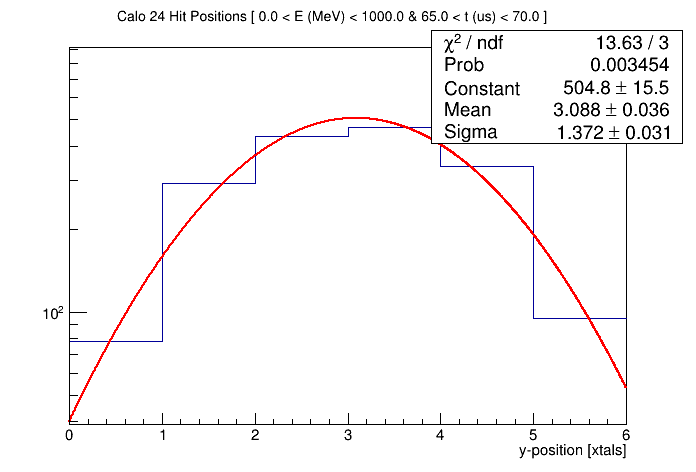

In [13]:
rebinFactors = [ #(time, position)
    #[2,1],
    #[2,5],
    #[2,10],
    #[2,50],
    [1,100],
    [2,100],
    [5,100],
    [10,100]
]

rebinnedFits = []
rebinnedMeans = []
rebinnedDevs = []

for (timeRebinFactor, positionRebinFactor) in rebinFactors:
    print("************************************************************************************")
    print("**************************** Starting rebin factors", 
                      timeRebinFactor, positionRebinFactor,"***************************")
    useCaloBins = False
    caloBinHighOffset = 3
    caloBinLowOffset = 0 # how much to offset the lower calo bin from RE bin.
    energyBin = 9
    energyBinHigh = 13
    slicesByCalo = []
    fitsByCalo = []
    meansByCalo = []
    devsByCalo = []

    #timeRebinFactor = 5
    #positionRebinFactor = 1

    for calo in range(1,25):
        print("Starting calo", calo)
        if(useCaloBins):
            energyBin = caloBinsLow[calo-1] + caloBinLowOffset
            energyBinHigh = energyBin + caloBinHighOffset
            print("     Using calo-by-calo bin ranges. For calo", calo,
                  "this is", energyBin, "-", energyBinHigh)


        h3 = f.Get("farline").Get("calo"+str(calo)).Get(yHistName).Clone()
        h3.GetYaxis().SetTitle("y-position [xtals]")

        #get the histogram for this calorimeter
        h3.GetZaxis().SetRange(energyBin,energyBinHigh)
        eMin = h3.GetZaxis().GetBinCenter(energyBin) - h3.GetZaxis().GetBinWidth(energyBin)/2.0
        eMax = h3.GetZaxis().GetBinCenter(energyBinHigh) + h3.GetZaxis().GetBinWidth(energyBinHigh)/2.0
        print("     Energy bin:", energyBin, "; Covering energy range", eMin,"-", eMax)
        hi = h3.Project3D("yx").Clone("h_E"+str(bin).zfill(2))
        hi.Rebin2D(timeRebinFactor, positionRebinFactor)
        hi.SetTitle("Calo "+str(calo)+
                    " Hit Positions vs. Time [ "+str(eMin)+" < E (MeV) < "+str(eMax)+" ]")
        slicesByCalo.append(hi.Clone("h3_E"+str(energyBin).zfill(2)+"_Calo"+str(calo)))

        hi.GetXaxis().UnZoom()
        h_mean = hi.ProjectionX().Clone("h_mean")
        h_mean.Reset()
        h_mean.SetTitle("Mean of Gaussian fit of Calo "+str(calo)+
                    " Hit Positions vs. Time [ "+str(eMin)+" < E (MeV) < "+str(eMax)+" ]")
        h_stdev = h_mean.Clone("h_stdev")
        h_stdev.SetTitle("#sigma of Gaussian fit of Calo "+str(calo)+
                    " Hit Positions vs. Time [ "+str(eMin)+" < E (MeV) < "+str(eMax)+" ]")

        
        h_mean2 = h_mean.Clone("h_mean2")
        h_stdev2 = h_stdev.Clone("h_stdev2")


        fits = []

        print("     Number of time bins:", hi.GetNbinsX())
        for bin in range(1, hi.GetNbinsX()+1):
            if(bin % 50 == 0):
                print("        Starting time bin:", bin)
            hi.GetXaxis().SetRange(bin,bin)
            h2 = hi.ProjectionY("", bin, bin)
            tMin = h3.GetXaxis().GetBinCenter(bin) - h3.GetXaxis().GetBinWidth(bin)/2.0
            tMax = h3.GetXaxis().GetBinCenter(bin) + h3.GetXaxis().GetBinWidth(bin)/2.0
            #h2.SetTitle("Bin "+str(bin))
            h2.SetTitle("Calo "+str(calo)+
                        " Hit Positions [ "+str(eMin)+" < E (MeV) < "+str(eMax)+" & "+str(tMin)+" < t (us) < "+str(tMax)+" ]")
            h2.Draw()
            if(h2.GetEntries() > 100):
                f1.SetParameters(1,1,1)
                for fwodnweo in range(2):
                    h2.Fit(f1,"RQ")
                f2.SetParameters(f1.GetParameter(0),f1.GetParameter(1),f1.GetParameter(2))
                #f2.FixParameter(1, f1.GetParameter(1))
                for fwodnweo in range(1):
                    h2.Fit(f2,"RQ")
                fits.append(( (bin, h3.GetXaxis().GetBinCenter(bin)),
                            [f2.GetParameter(x) for x in range(3)],
                            [f2.GetParError(x) for x in range(3)],
                            [f2.GetChisquare(), f2.GetNDF()],
                            [f1.GetParameter(x) for x in range(3)],
                            [f1.GetParError(x) for x in range(3)],
                            [f1.GetChisquare(), f1.GetNDF()]))
                
                h_mean.SetBinContent(bin, f1.GetParameter(1))
                h_mean.SetBinError(bin, f1.GetParError(1))
                h_stdev.SetBinContent(bin, f1.GetParameter(2))
                h_stdev.SetBinError(bin, f1.GetParError(2))
                
                h_mean2.SetBinContent(bin, f2.GetParameter(1))
                h_mean2.SetBinError(bin, f2.GetParError(1))
                h_stdev2.SetBinContent(bin, f2.GetParameter(2))
                h_stdev2.SetBinError(bin, f2.GetParError(2))
                
            c.Draw()
            #c.Print("./images/PositionMovie_"+str(focus)+"_"+str(bin).zfill(3)+".png")
        meansByCalo.append((h_mean.Clone("h_mean_"+str(calo)), h_mean2.Clone("h_mean2_"+str(calo))))
        devsByCalo.append((h_stdev.Clone("h_stdev_"+str(calo)), h_stdev2.Clone("h_stdev2_"+str(calo)) ))
        fitsByCalo.append((calo, fits))
        
    rebinnedFits.append(fitsByCalo)
    rebinnedMeans.append(meansByCalo)
    rebinnedDevs.append(devsByCalo)

In [14]:
print(len(rebinnedFits))

4


In [15]:
for mi in rebinnedMeans:
    print(mi[0][0].GetNbinsX())

140
70
28
14


---

### And now lets make a plot of the calculated means / stdevs vs. the rebinning factor

In [16]:
npar = 2
flin = r.TF1("flin", "pol"+str(npar-1), 25, 400, npar)
flin.SetParameters(3,-0.0001)
flin.SetParLimits(0,0,100000)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>:

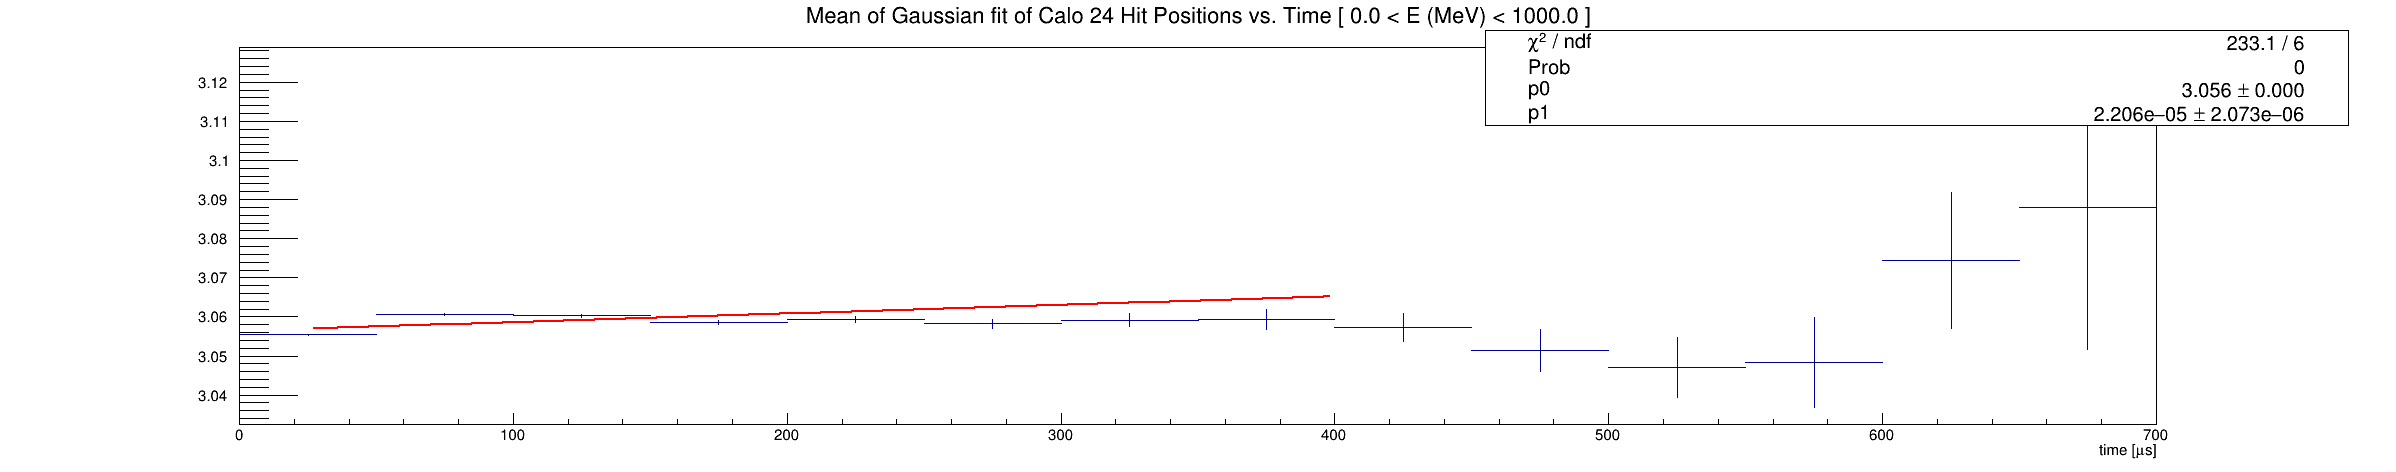

In [17]:
rebinnedLinearFits_mean = []

for i, (timeRebinFactor, positionRebinFactor) in enumerate(rebinFactors):
    meansByCalo = rebinnedMeans[i]
    
    linearFits_mean = []
    for j, (h_mean, h_mean2) in enumerate(meansByCalo):
        flin.SetParameters(3,-0.0001)

        c = r.TCanvas("c","c",2400,500)
        h_mean.Draw("ple")
        for k in range(2):
            h_mean.Fit(flin,"REMQ")

        linearFits_mean.append(([flin.GetParameter(x) for x in range(npar)], 
                                [flin.GetParError(x) for x in range(npar)], 
                                [flin.GetChisquare(), flin.GetNDF()],
                                j+1 ))

        c.Draw()
    #print(linearFits_mean)
    
    rebinnedLinearFits_mean.append(linearFits_mean)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>:

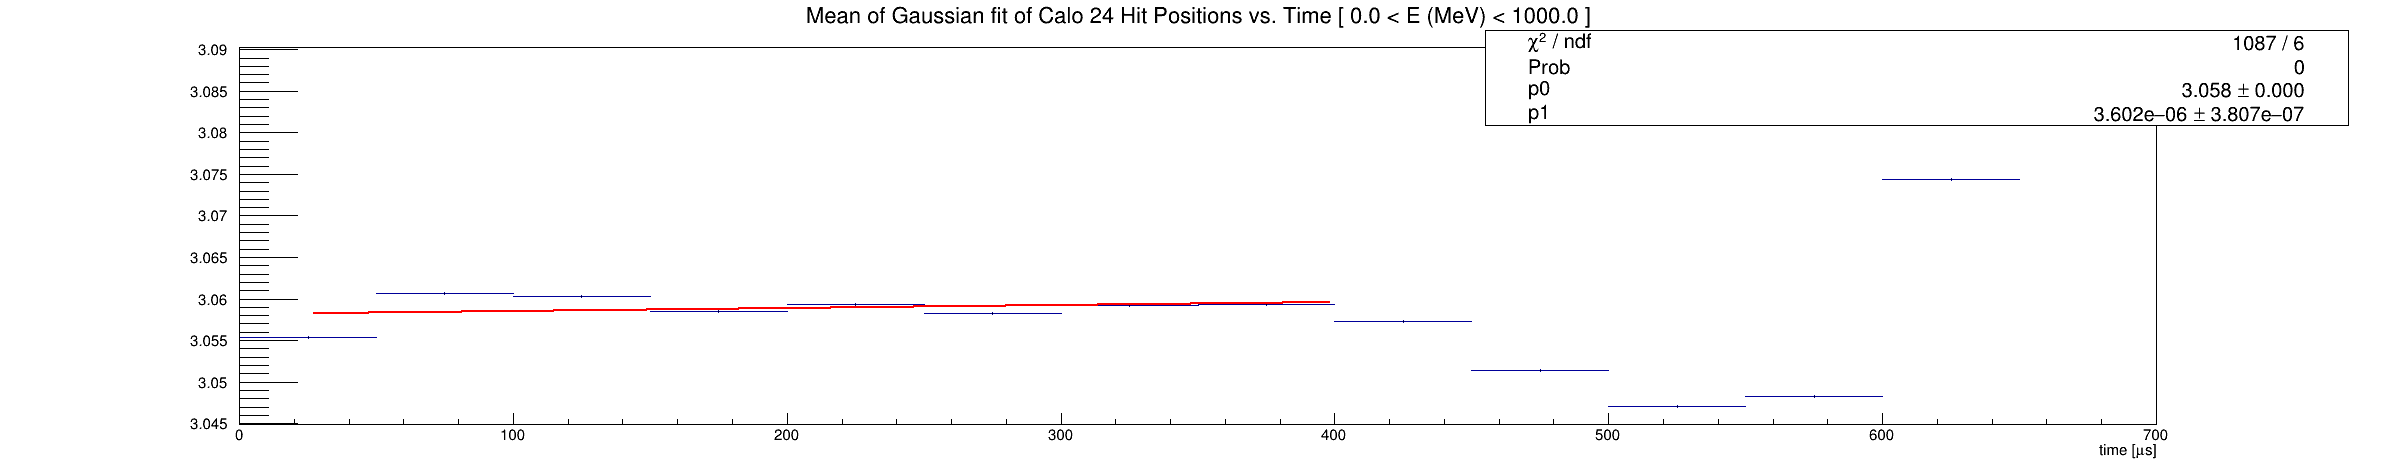

In [18]:
rebinnedLinearFits_mean2 = []

for i, (timeRebinFactor, positionRebinFactor) in enumerate(rebinFactors):
    meansByCalo = rebinnedMeans[i]
    
    linearFits_mean2 = []
    for j, (h_mean, h_mean2) in enumerate(meansByCalo):
        flin.SetParameters(3,-0.0001)

        c = r.TCanvas("c","c",2400,500)
        h_mean2.Draw("ple")
        for k in range(2):
            h_mean2.Fit(flin,"REMQ")

        linearFits_mean2.append(([flin.GetParameter(x) for x in range(npar)], 
                                [flin.GetParError(x) for x in range(npar)], 
                                [flin.GetChisquare(), flin.GetNDF()],
                                j+1 ))

        c.Draw()
    #print(linearFits_mean)
    
    rebinnedLinearFits_mean2.append(linearFits_mean2)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>:

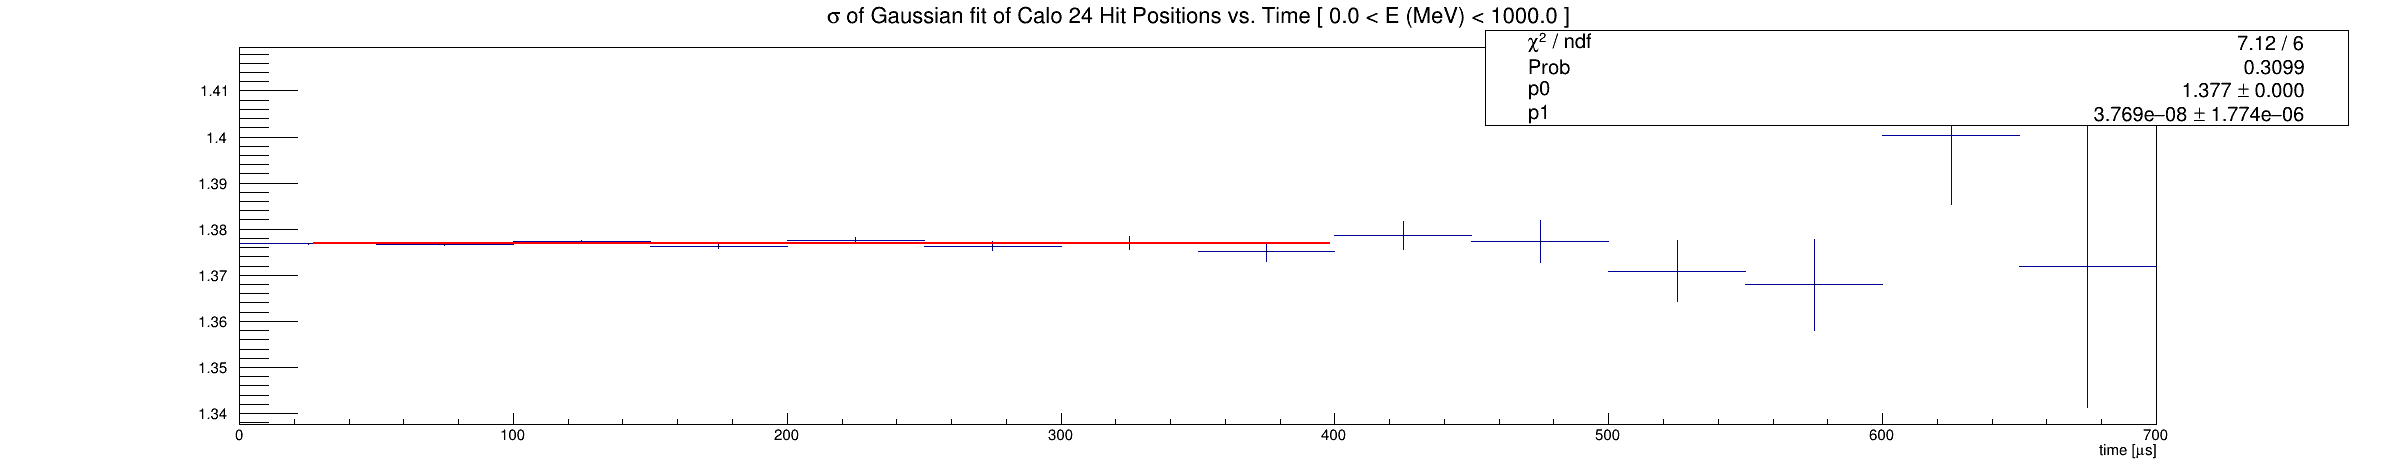

In [19]:
rebinnedLinearFits_stdev = []

for i, (timeRebinFactor, positionRebinFactor) in enumerate(rebinFactors):
    devsByCalo = rebinnedDevs[i]
    linearFits_stdev = []
    for j, (h_mean, h_mean2) in enumerate(devsByCalo):
        flin.SetParameters(3,-0.0001)

        c = r.TCanvas("c","c",2400,500)
        h_mean.Draw("ple")
        for k in range(2):
            h_mean.Fit(flin,"REMQ")

        linearFits_stdev.append(([flin.GetParameter(x) for x in range(npar)], 
                                [flin.GetParError(x) for x in range(npar)], 
                                [flin.GetChisquare(), flin.GetNDF()],
                                j+1))

        c.Draw()
    #print(linearFits_stdev)
    
    rebinnedLinearFits_stdev.append(linearFits_stdev)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TCanvas::Constructor>:

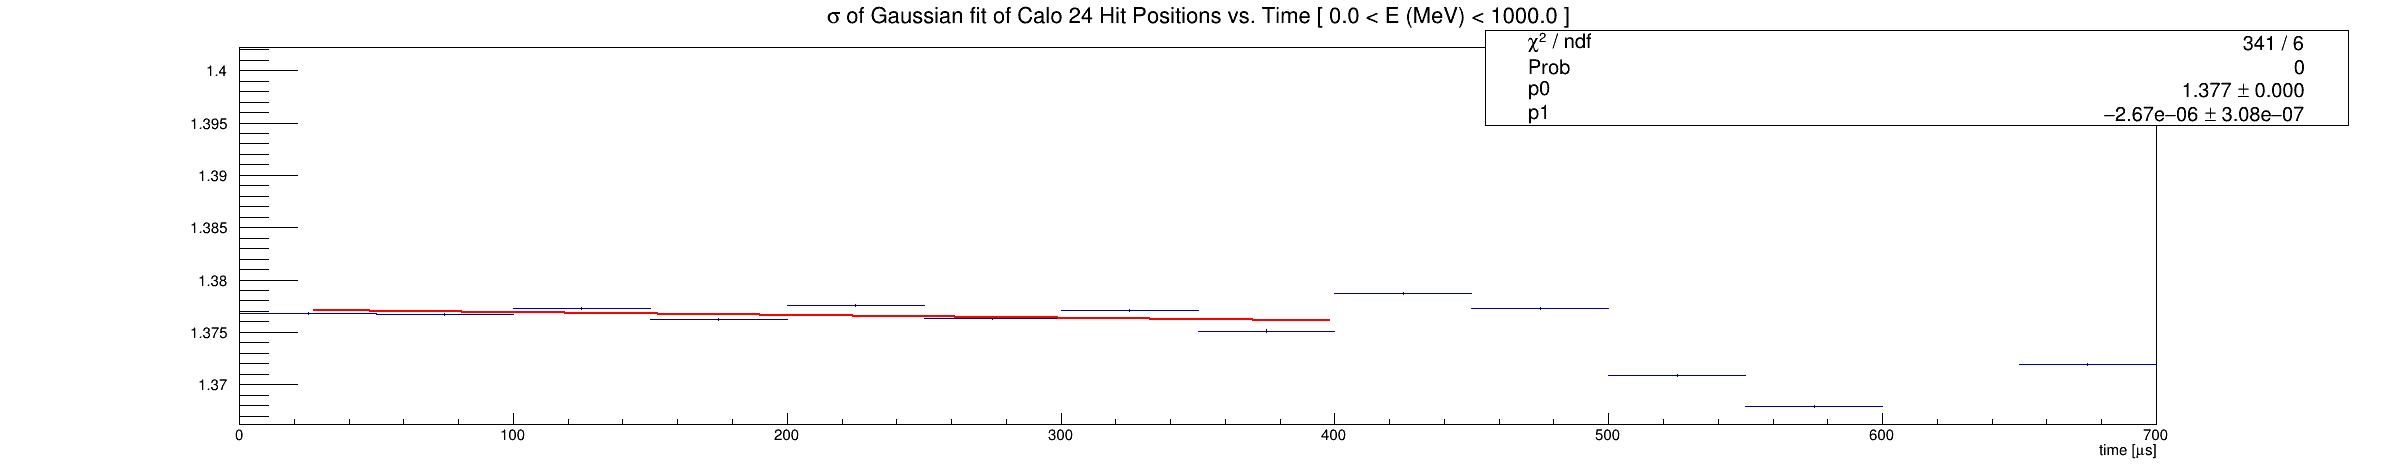

In [20]:
rebinnedLinearFits_stdev2 = []

for i, (timeRebinFactor, positionRebinFactor) in enumerate(rebinFactors):
    devsByCalo = rebinnedDevs[i]
    linearFits_stdev2 = []
    for j, (h_mean, h_mean2) in enumerate(devsByCalo):
        flin.SetParameters(3,-0.0001)

        c = r.TCanvas("c","c",2400,500)
        h_mean2.Draw("ple")
        for k in range(2):
            h_mean2.Fit(flin,"REMQ")

        linearFits_stdev2.append(([flin.GetParameter(x) for x in range(npar)], 
                                [flin.GetParError(x) for x in range(npar)], 
                                [flin.GetChisquare(), flin.GetNDF()],
                                j+1))

        c.Draw()
    #print(linearFits_stdev)
    
    rebinnedLinearFits_stdev2.append(linearFits_stdev2)

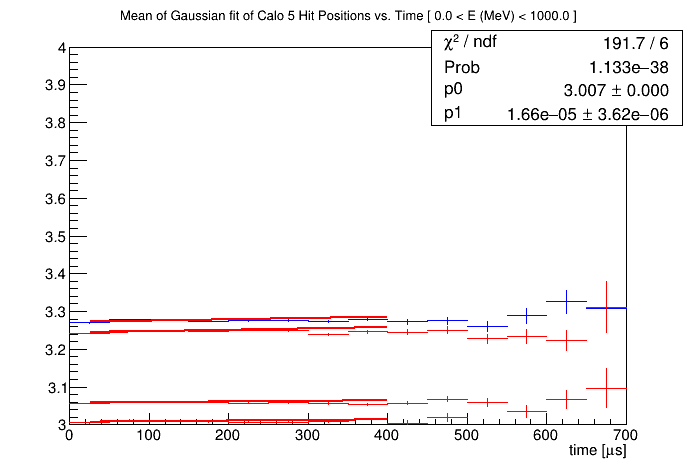

In [21]:
c = r.TCanvas()

i = 4
rebinnedMeans[3][i][0].GetYaxis().SetRangeUser(3,4)
rebinnedMeans[3][i][0].SetMarkerColor(4)
rebinnedMeans[3][i][0].SetLineColor(4)
rebinnedMeans[3][i][0].Draw("SAME")

for i in [1,2,5]:
    rebinnedMeans[3][i][0].SetMarkerColor(2)
    rebinnedMeans[3][i][0].SetLineColor(2)
    rebinnedMeans[3][i][0].Draw("SAME")

c.Draw()

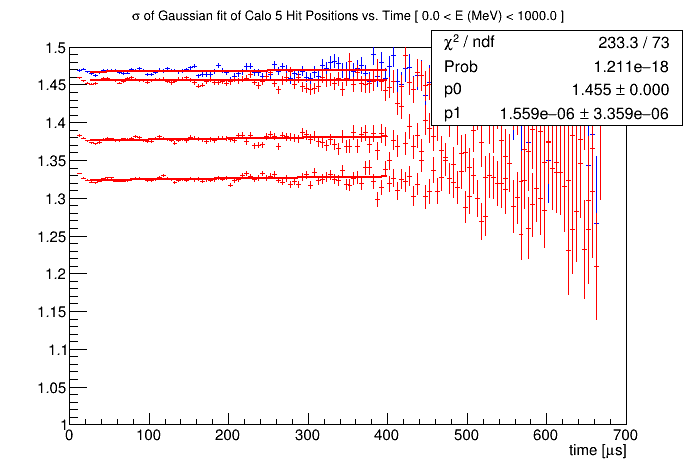

In [22]:
c = r.TCanvas()

#which rebinning of position
mean = 0

#calo
i = 4

rebinnedDevs[mean][i][0].GetYaxis().SetRangeUser(1,1.5)
rebinnedDevs[mean][i][0].SetMarkerColor(4)
rebinnedDevs[mean][i][0].SetLineColor(4)
rebinnedDevs[mean][i][0].Draw("")

for i in [1,2,5]: #calo
    rebinnedDevs[mean][i][0].SetMarkerColor(2)
    rebinnedDevs[mean][i][0].SetLineColor(2)
    rebinnedDevs[mean][i][0].Draw("SAME")

c.Draw()

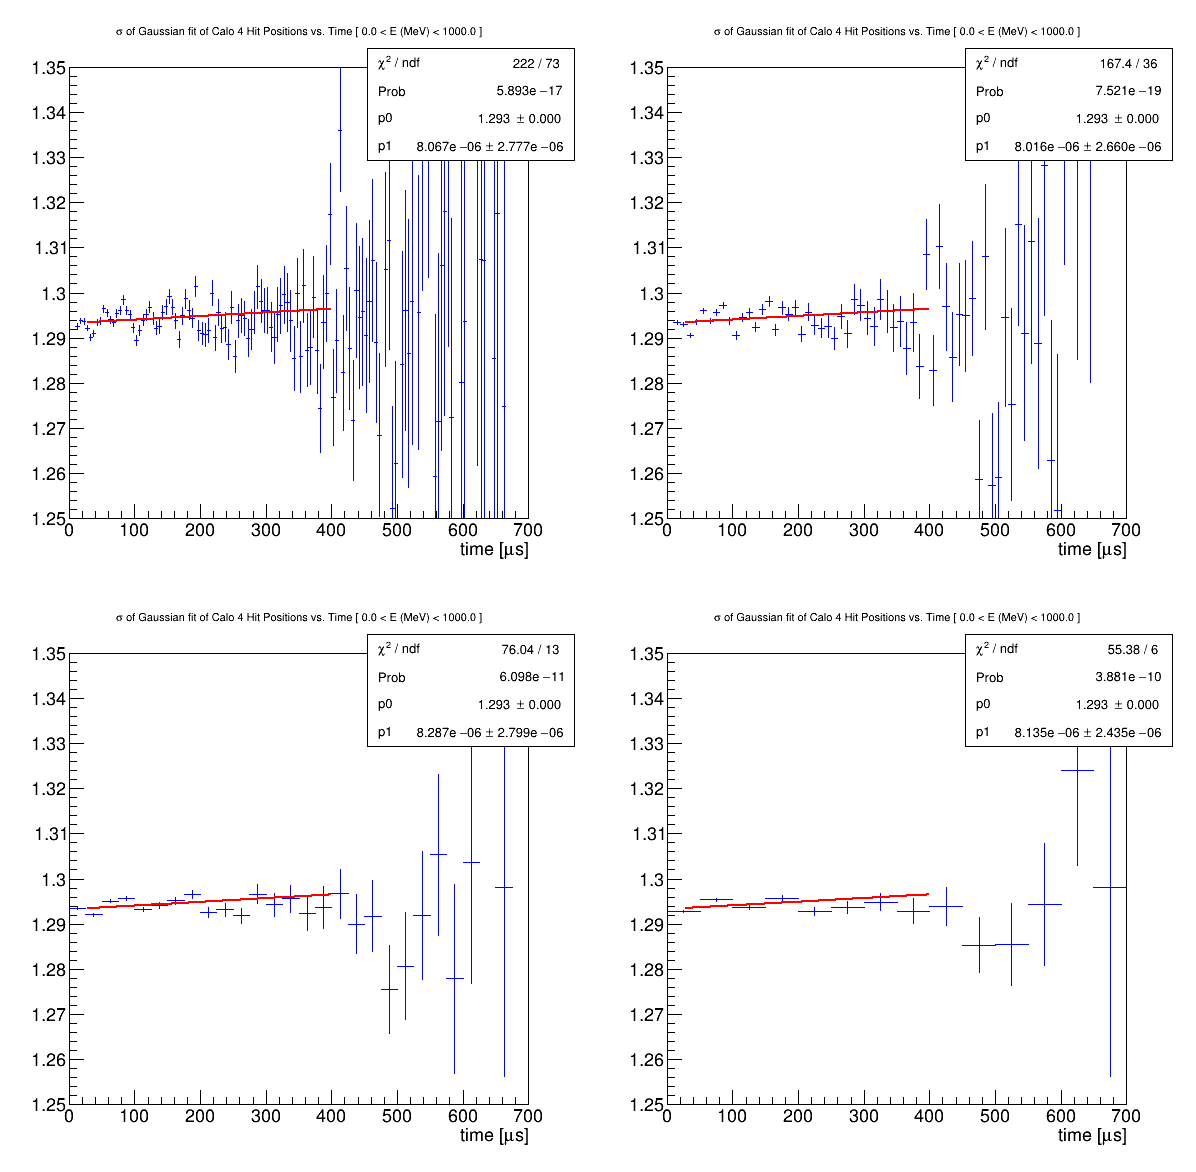

In [23]:
nPlots = len(rebinnedDevs)
cols = 2
calo = 3

c = r.TCanvas("c","c", cols*600, int(nPlots/cols)*600)
c.Divide(cols,int(np.ceil(nPlots/cols)))
for i, mi in enumerate(rebinnedDevs):
    c.cd(i+1)
    mi[calo][0].GetYaxis().SetRangeUser(1.25,1.35)
    mi[calo][0].SetMarkerColor(4)
    mi[calo][0].SetLineColor(4)
    mi[calo][0].Draw("")
c.Draw()

---

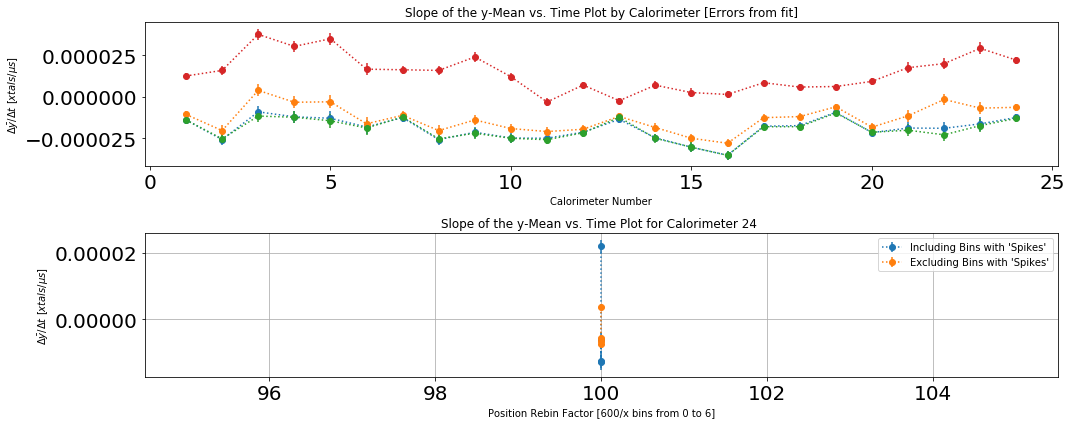

In [24]:
#mean plot

fig,ax = plt.subplots(2,1,figsize=(15,6))

ax[0].set_title("Slope of the y-Mean vs. Time Plot by Calorimeter [Errors from fit]")
ax[0].set_xlabel("Calorimeter Number")
ax[0].set_ylabel(r"$\Delta \bar{y} / \Delta t$ $[xtals/ \mu s]$")

for i, (timeRebinFactor, positionRebinFactor) in enumerate(rebinFactors):
    means = rebinnedLinearFits_mean[i]
    
    xvals = [x+1 for x in range(len(means))]
    xerr = 0
    yvals = [x[0][1] for x in means]
    yerr = [x[1][1] for x in means]
    
    ax[0].errorbar(xvals, yvals, yerr=yerr, xerr=xerr, fmt="o:",
                   label="Position/Time Rebin: "+str(positionRebinFactor)+"/"+str(timeRebinFactor))
    ax[0].grid()
    
calo = 24
xvals2 = [x[1] for x in rebinFactors]
#for i, (timeRebinFactor, positionRebinFactor) in enumerate(rebinFactors):
ax[1].set_title("Slope of the y-Mean vs. Time Plot for Calorimeter "+str(calo)+" ")
ax[1].set_xlabel("Position Rebin Factor [600/x bins from 0 to 6]")
ax[1].set_ylabel(r"$\Delta \bar{y} / \Delta t$ $[xtals/ \mu s]$")


yvals2 = [x[calo-1][0][1] for x in rebinnedLinearFits_mean]
yerr2 = [x[calo-1][1][1] for x in rebinnedLinearFits_mean]
ax[1].errorbar(xvals2, yvals2, fmt="o:", label="Including Bins with 'Spikes'", yerr=yerr2)

yvals3 = [x[calo-1][0][1] for x in rebinnedLinearFits_mean2]
yerr3 = [x[calo-1][1][1] for x in rebinnedLinearFits_mean2]
ax[1].errorbar(xvals2, yvals3, fmt="o:", label="Excluding Bins with 'Spikes'", yerr=0)

plt.tight_layout()
plt.legend()    
plt.grid()
plt.show()

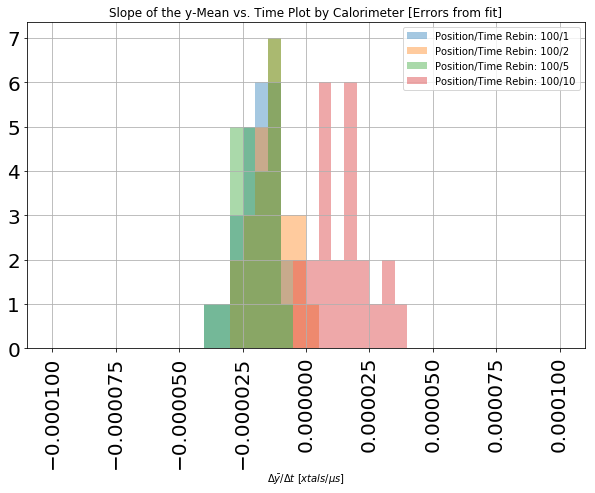

In [25]:
#mean plot

fig,ax = plt.subplots(figsize=(10,6))

plt.title("Slope of the y-Mean vs. Time Plot by Calorimeter [Errors from fit]")
plt.xlabel(r"$\Delta \bar{y} / \Delta t$ $[xtals/ \mu s]$")

for i, (timeRebinFactor, positionRebinFactor) in enumerate(rebinFactors):
    means = rebinnedLinearFits_mean[i]
    
    xvals = [x+1 for x in range(len(means))]
    xerr = 0
    yvals = [x[0][1] for x in means]
    yerr = [x[1][1] for x in means]
    
    plt.hist(yvals, alpha=0.4, range=(-0.0001,0.0001), bins=40, 
             label="Position/Time Rebin: "+str(positionRebinFactor)+"/"+str(timeRebinFactor))
    
plt.xticks(rotation=90)
plt.legend()    
plt.grid()
plt.show()

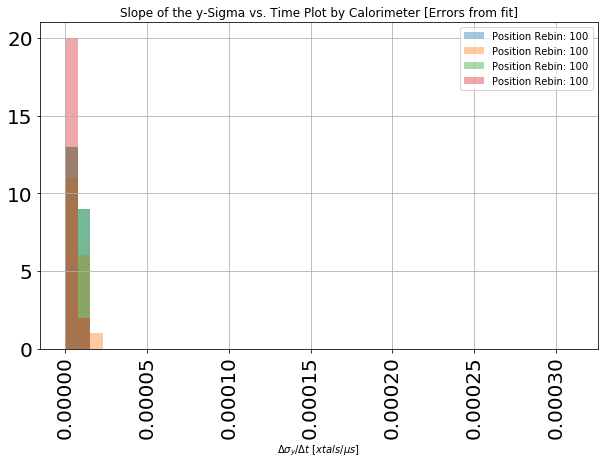

In [26]:
#width plot

fig,ax = plt.subplots(figsize=(10,6))

plt.title("Slope of the y-Sigma vs. Time Plot by Calorimeter [Errors from fit]")
plt.xlabel(r"$\Delta \sigma_{y} / \Delta t$ $[xtals/ \mu s]$")

for i, (timeRebinFactor, positionRebinFactor) in enumerate(rebinFactors):
    means = rebinnedLinearFits_stdev[i]
    
    xvals = [x+1 for x in range(len(means))]
    xerr = 0
    yvals = [x[0][1] for x in means]
    yerr = [x[1][1] for x in means]
    
    plt.hist(yvals, alpha=0.4, range=(0,0.00031), bins=40, label="Position Rebin: "+str(positionRebinFactor))

plt.xticks(rotation=90)
plt.legend()    
plt.grid()
plt.show()

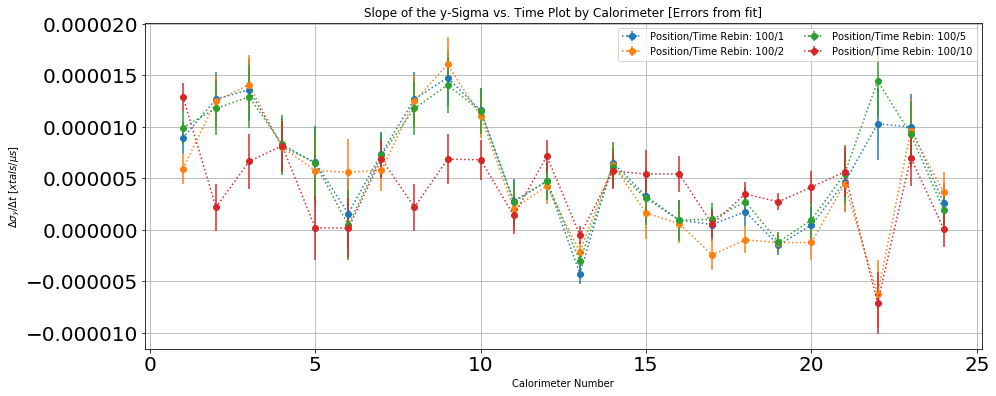

In [27]:
#width plot

fig,ax = plt.subplots(figsize=(15,6))

plt.title("Slope of the y-Sigma vs. Time Plot by Calorimeter [Errors from fit]")
plt.xlabel("Calorimeter Number")
plt.ylabel(r"$\Delta \sigma_{y} / \Delta t$ $[xtals/ \mu s]$")

for i, (timeRebinFactor, positionRebinFactor) in enumerate(rebinFactors):
    means = rebinnedLinearFits_stdev[i]
    
    xvals = [x+1 for x in range(len(means))]
    xerr = 0
    yvals = [x[0][1] for x in means]
    yerr = [x[1][1] for x in means]
    
    plt.errorbar(xvals, yvals, yerr=yerr, xerr=xerr, fmt="o:",
                label="Position/Time Rebin: "+str(positionRebinFactor)+"/"+str(timeRebinFactor))
    
plt.legend(ncol=2)    
plt.grid()
plt.show()

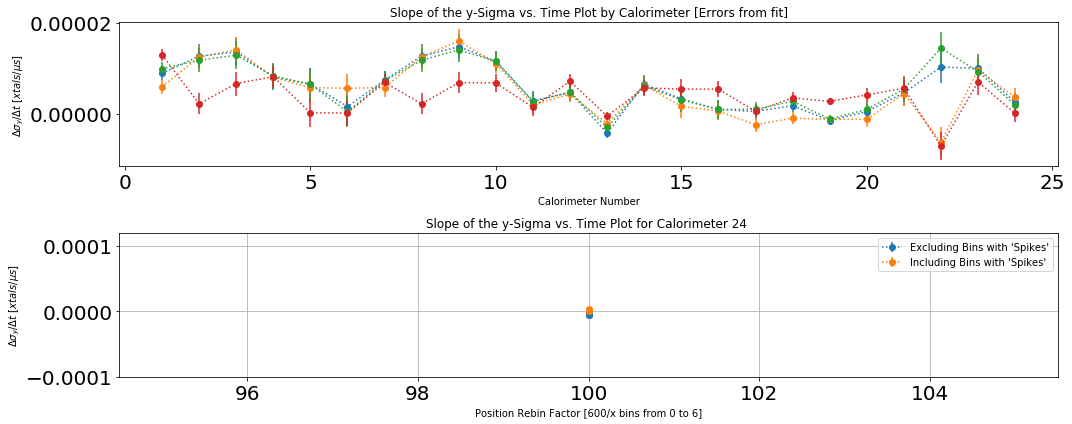

In [28]:
#stdev plot

fig,ax = plt.subplots(2,1,figsize=(15,6))

ax[0].set_title("Slope of the y-Sigma vs. Time Plot by Calorimeter [Errors from fit]")
ax[0].set_xlabel("Calorimeter Number")
ax[0].set_ylabel(r"$\Delta \sigma_{y} / \Delta t$ $[xtals/ \mu s]$")

for i, (timeRebinFactor, positionRebinFactor) in enumerate(rebinFactors):
    means = rebinnedLinearFits_stdev[i]
    
    xvals = [x+1 for x in range(len(means))]
    xerr = 0
    yvals = [x[0][1] for x in means]
    yerr = [x[1][1] for x in means]
    
    ax[0].errorbar(xvals, yvals, yerr=yerr, xerr=xerr, fmt="o:",
                  label="Position/Time Rebin: "+str(positionRebinFactor)+"/"+str(timeRebinFactor))
    ax[0].grid()
    
calo = 24
xvals2 = [x[1] for x in rebinFactors]
#for i, (timeRebinFactor, positionRebinFactor) in enumerate(rebinFactors):
ax[1].set_title("Slope of the y-Sigma vs. Time Plot for Calorimeter "+str(calo)+" ")
ax[1].set_xlabel("Position Rebin Factor [600/x bins from 0 to 6]")
ax[1].set_ylabel(r"$\Delta \sigma_{y} / \Delta t$ $[xtals/ \mu s]$")

yvals2 = [x[calo-1][0][1] for x in rebinnedLinearFits_stdev2]
yerr2 = [x[calo-1][1][1] for x in rebinnedLinearFits_stdev2]
ax[1].errorbar(xvals2, yvals2, fmt="o:", yerr=yerr2, label="Excluding Bins with 'Spikes'")

yvals2 = [x[calo-1][0][1] for x in rebinnedLinearFits_stdev]
yerr2 = [x[calo-1][1][1] for x in rebinnedLinearFits_stdev]
ax[1].errorbar(xvals2, yvals2, fmt="o:", yerr=yerr2, label="Including Bins with 'Spikes'")

ax[1].set_ylim(-0.0001,0.00012)

plt.tight_layout()
plt.legend()    
plt.grid()
plt.show()

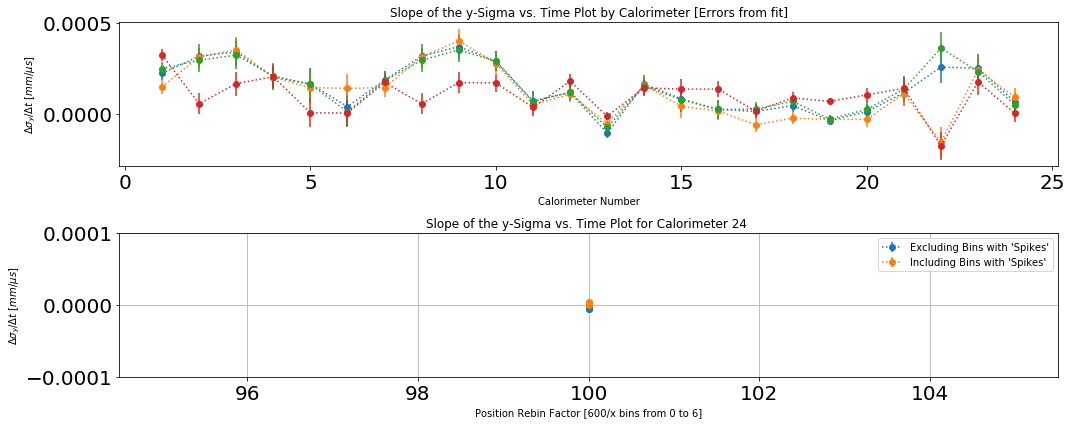

In [29]:
#stdev plot

fig,ax = plt.subplots(2,1,figsize=(15,6))

ax[0].set_title("Slope of the y-Sigma vs. Time Plot by Calorimeter [Errors from fit]")
ax[0].set_xlabel("Calorimeter Number")
ax[0].set_ylabel(r"$\Delta \sigma_{y} / \Delta t$ $[mm/ \mu s]$")

for i, (timeRebinFactor, positionRebinFactor) in enumerate(rebinFactors):
    means = rebinnedLinearFits_stdev[i]
    
    xvals = [x+1 for x in range(len(means))]
    xerr = 0
    yvals = [x[0][1]*25. for x in means]
    yerr = [x[1][1]*25. for x in means]
    
    ax[0].errorbar(xvals, yvals, yerr=yerr, xerr=xerr, fmt="o:",
                  label="Position/Time Rebin: "+str(positionRebinFactor)+"/"+str(timeRebinFactor))
    ax[0].grid()
    
calo = 24
xvals2 = [x[1] for x in rebinFactors]
#for i, (timeRebinFactor, positionRebinFactor) in enumerate(rebinFactors):
ax[1].set_title("Slope of the y-Sigma vs. Time Plot for Calorimeter "+str(calo)+" ")
ax[1].set_xlabel("Position Rebin Factor [600/x bins from 0 to 6]")
ax[1].set_ylabel(r"$\Delta \sigma_{y} / \Delta t$ $[mm / \mu s]$")

yvals2 = [x[calo-1][0][1] for x in rebinnedLinearFits_stdev2]
yerr2 = [x[calo-1][1][1] for x in rebinnedLinearFits_stdev2]
ax[1].errorbar(xvals2, yvals2, fmt="o:", yerr=yerr2, label="Excluding Bins with 'Spikes'")

yvals2 = [x[calo-1][0][1] for x in rebinnedLinearFits_stdev]
yerr2 = [x[calo-1][1][1] for x in rebinnedLinearFits_stdev]
ax[1].errorbar(xvals2, yvals2, fmt="o:", yerr=yerr2, label="Including Bins with 'Spikes'")

ax[1].set_ylim(-0.0001,0.0001)

plt.tight_layout()
plt.legend()    
plt.grid()
plt.show()

---

### Lets compare some slopes with an without exluding the bins

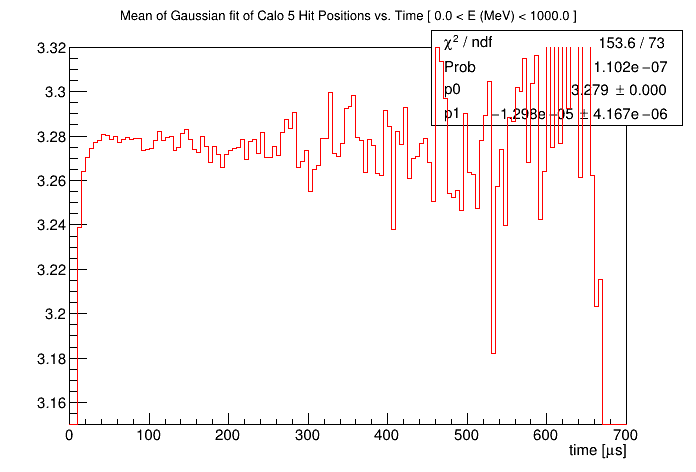

In [30]:
c = r.TCanvas()

mean = 0
i = 4
rebinnedMeans[mean][i][0].GetYaxis().SetRangeUser(3.15,3.32)
rebinnedMeans[mean][i][0].SetMarkerColor(4)
rebinnedMeans[mean][i][0].SetLineColor(4)
rebinnedMeans[mean][i][0].Draw("hist")

rebinnedMeans[mean][i][1].SetMarkerColor(2)
rebinnedMeans[mean][i][1].SetLineColor(2)
rebinnedMeans[mean][i][1].Draw("hist SAME")

c.Draw()